# Data Extracting

In [5]:
# Imports & Setup
import os
import json
import math
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import BDay
from getpass import getpass

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

ALPHAVANTAGE_API_KEY = getpass('Enter your Alpha Vantage API Key: ')

In [6]:
def get_date_range_by_business_days(start_date_str: str, num_periods: int) -> tuple[str, str]:
    """
    Given a start date string and a number of business days, returns a tuple
    of two date strings (start_date, end_date) where end_date is num_periods
    business days from start_date. If num_periods is negative, the dates are
    swapped to ensure the first date is before the second.

    Args:
        start_date_str: The starting date as a string in 'YYYY-MM-DD' format.
        num_periods: The number of business days to add (can be negative).

    Returns:
        A tuple of two date strings (date1, date2) where date1 <= date2.
    """
    start_date = pd.to_datetime(start_date_str)

    if num_periods >= 0:
        end_date = start_date + BDay(num_periods)
        date1_str = start_date.strftime('%Y-%m-%d')
        date2_str = end_date.strftime('%Y-%m-%d')
    else:
        end_date = start_date + BDay(num_periods)
        date1_str = end_date.strftime('%Y-%m-%d')
        date2_str = start_date.strftime('%Y-%m-%d')

    return (date1_str, date2_str)

print(get_date_range_by_business_days('2021-01-01', 500))
print(get_date_range_by_business_days('2021-01-15', -5))

('2021-01-01', '2022-12-02')
('2021-01-08', '2021-01-15')


In [7]:
def get_stock_data(symbol: str, start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Downloads Yahoo Finance historical data for a single stock symbol.

    Args:
        symbol: The stock ticker symbol.
        start_date: Optional start date string in 'YYYY-MM-DD' format.
        end_date: Optional end date string in 'YYYY-MM-DD' format.

    Returns:
        A pandas DataFrame with Date as the index and columns for open, high,
        low, close, adjusted_close, and volume, all in lowercase.
    """
    # Download data for the single symbol
    df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Ensure Date is the index (it usually is by default with yfinance)
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Handle potential MultiIndex columns by flattening before lowercasing
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns.values] # Flatten MultiIndex to string

    # Convert column names to lowercase
    df.columns = df.columns.str.lower()

    # Rename 'adj close' to 'adjusted_close' if it exists
    if 'adj close' in df.columns:
        df = df.rename(columns={'adj close': 'adjusted_close'})

    # Select and reorder relevant columns
    # Ensure all expected columns exist before selecting
    required_cols = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
    for col in required_cols:
        if col not in df.columns:
            # Handle cases where a column might be missing (e.g., for very new stocks)
            # For this context, we might raise an error or log a warning
            print(f"Warning: Column '{col}' not found for symbol {symbol}. Skipping.")
            # Or, add the column with NaNs
            # df[col] = np.nan

    # Filter for required columns that are actually present
    cols_to_select = [col for col in required_cols if col in df.columns]
    df = df[cols_to_select]


    return df

In [8]:
# Setting up the stock symbol to use and the periods to consider
tickers = ["NVDA", "FSLR", "MSFT", "TSLA", "SPY"] # Possible stocks to analyze
SYMBOL = tickers[0]  # Choose NVIDIA for this analysis
PERIODS = 500
START_DATE = '2025-06-01' # Changed start date

# Optional: compact vs full (full returns all history, compact ~100 days)
OUTPUT_SIZE = "full"  # "full" or "compact"

# Basic validation
if ALPHAVANTAGE_API_KEY == "REPLACE_WITH_YOUR_KEY":
    print("Please set ALPHAVANTAGE_API_KEY (above) to your real Alpha Vantage key.")
else:
    print("API key detected.")
print(f"Using symbol: {SYMBOL}")

API key detected.
Using symbol: NVDA


In [9]:
def fetch_alpha_vantage_daily_adjusted(symbol: str, apikey: str, output_size: str = "compact", start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Fetch TIME_SERIES_DAILY_ADJUSTED from Alpha Vantage.
    Returns a DataFrame with columns: ['open','high','low','close','adjusted_close','volume','dividend_amount','split_coefficient']
    indexed by pandas datetime in ascending order, filtered by start and end dates if provided.
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": symbol,
        "apikey": apikey,
        "outputsize": output_size
    }
    r = requests.get(url, params=params)
    if r.status_code != 200:
        raise RuntimeError(f"HTTP error {r.status_code}: {r.text}")
    data = r.json()

    if "Error Message" in data:
        raise ValueError(f"API returned error: {data['Error Message']}")
    if "Time Series (Daily)" not in data:
        raise ValueError(f"Unexpected payload (rate limit or invalid key?): {json.dumps(data)[:500]}")


    ts = data["Time Series (Daily)"]
    df = pd.DataFrame.from_dict(ts, orient="index", dtype=float)
    df.index = pd.to_datetime(df.index)
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. adjusted close": "adjusted_close",
        "6. volume": "volume",
        "7. dividend amount": "dividend_amount",
        "8. split coefficient": "split_coefficient"
    })
    df = df.sort_index()  # ascending

    # Filter by date range if start_date or end_date are provided
    if start_date:
        start_datetime = pd.to_datetime(start_date)
        df = df[df.index >= start_datetime]
    if end_date:
        end_datetime = pd.to_datetime(end_date)
        df = df[df.index <= end_datetime]

    return df

try:
    df = fetch_alpha_vantage_daily_adjusted(SYMBOL,
                                            ALPHAVANTAGE_API_KEY,
                                            output_size=OUTPUT_SIZE,
                                            start_date=START_DATE,
                                            end_date='2025-09-01') # Changed end date
except:
    # You found a stock that requires a premium access to the Alpha Vantage API. Rollback to the Yahoo Finance API
    df = get_stock_data(SYMBOL, start_date=START_DATE, end_date='2025-09-01') # Changed end date

print(df.head(3))
print(df.tail(3))

                  open        high         low       close  adjusted_close  \
Date                                                                         
2025-06-02  135.490005  138.119995  135.399994  137.380005      137.362717   
2025-06-03  138.779999  142.000000  137.949997  141.220001      141.202225   
2025-06-04  142.190002  142.389999  139.539993  141.919998      141.902145   

               volume  
Date                   
2025-06-02  197663100  
2025-06-03  225578800  
2025-06-04  167120800  
                  open        high         low       close  adjusted_close  \
Date                                                                         
2025-08-27  181.979996  182.490005  179.100006  181.600006      181.589767   
2025-08-28  180.820007  184.470001  176.410004  180.169998      180.159836   
2025-08-29  178.110001  178.149994  173.149994  174.179993      174.170166   

               volume  
Date                   
2025-08-27  235518900  
2025-08-28  281787800  
20

#Exploratory Statistics

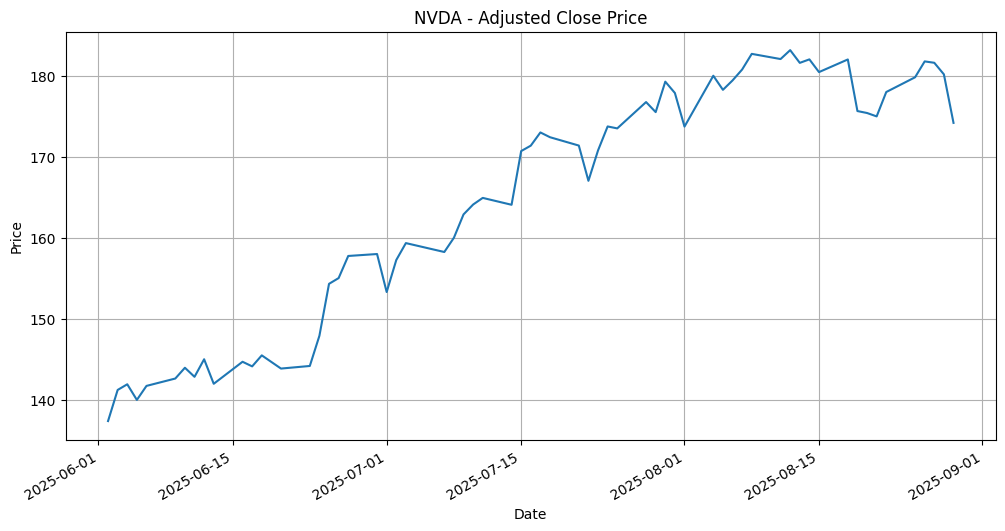

In [10]:
# Line plot of adjusted close price
plt.figure(figsize=(12, 6))
df['adjusted_close'].plot(title=f'{SYMBOL} - Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

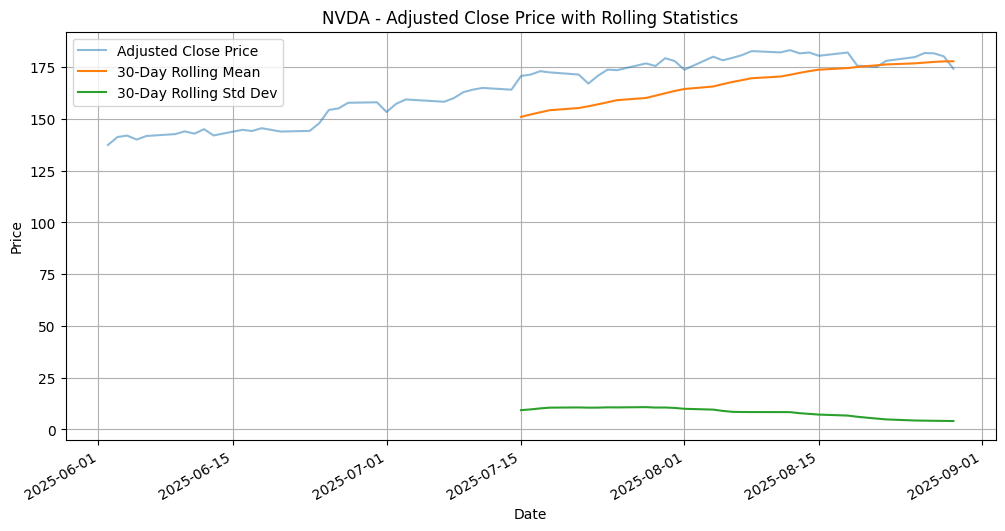

In [11]:
# Rolling statistics (e.g., 30-day rolling mean and standard deviation)
rolling_mean = df['adjusted_close'].rolling(window=30).mean()
rolling_std = df['adjusted_close'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
df['adjusted_close'].plot(label='Adjusted Close Price', alpha=0.5)
rolling_mean.plot(label='30-Day Rolling Mean')
rolling_std.plot(label='30-Day Rolling Std Dev')
plt.title(f'{SYMBOL} - Adjusted Close Price with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Summary statistics
print("\nSummary Statistics for Adjusted Close Price:")
display(df['adjusted_close'].describe())


Summary Statistics for Adjusted Close Price:


count     63.000000
mean     164.735811
std       15.023143
min      137.362717
25%      150.591507
50%      170.770370
75%      178.114952
max      183.149673
Name: adjusted_close, dtype: float64

# Identifying Time Series Components

In [13]:
# Calculate the log of the adjusted close price
df['log_price'] = np.log(df['adjusted_close'])

# Display the first few rows to confirm the new column
display(df.head())

,open,high,low,close,adjusted_close,volume,log_price
Date,,,,,,,
2025-06-02,135.490005,138.119995,135.399994,137.380005,137.362717,197663100,4.922625
2025-06-03,138.779999,142.000000,137.949997,141.220001,141.202225,225578800,4.950193
2025-06-04,142.190002,142.389999,139.539993,141.919998,141.902145,167120800,4.955138
2025-06-05,142.169998,144.000000,138.830002,139.990005,139.972397,231397900,4.941445
2025-06-06,142.509995,143.270004,141.509995,141.720001,141.702164,153986200,4.953727


In [14]:
#
def adf_kpss_report(series: pd.Series, name: str = "series") -> Tuple[float, float]:
    """Run ADF & KPSS and print a compact summary. Returns (adf_p, kpss_p)."""
    series = series.dropna()
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series, autolag="AIC")
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression="c", nlags="auto")
    print(f"\n=== Stationarity Report for {name} ===")
    print(f"ADF:  stat={adf_stat: .4f}, p={adf_p: .4f} | crit={adf_crit}")
    print(f"KPSS: stat={kpss_stat: .4f}, p={kpss_p: .4f} | crit={kpss_crit}")
    return adf_p, kpss_p

# Determine d by iteratively differencing the log-price
y = df["log_price"].copy()
d = 0
max_d = 2

while d <= max_d:
    adf_p, kpss_p = adf_kpss_report(y, name=f"log_price differenced {d} times")
    adf_ok = adf_p < 0.05     # reject unit root
    kpss_ok = kpss_p > 0.05   # fail to reject stationarity

    if adf_ok and kpss_ok:
        print(f"\nSelected d = {d} (series appears stationary)." )
        break
    else:
        d += 1
        if d > max_d:
            print("\nReached maximum differencing (d=2). Proceeding with d=2 even if borderline.")
            d = max_d
            break
        y = y.diff()  # difference once and test again

# Keep a reference to the stationary (d-differenced) series for ACF/PACF
y_stationary = df["log_price"].diff(d).dropna() if d > 0 else df["log_price"].dropna()


=== Stationarity Report for log_price differenced 0 times ===
ADF:  stat=-1.9033, p= 0.3305 | crit={'1%': np.float64(-3.540522678829176), '5%': np.float64(-2.9094272025108254), '10%': np.float64(-2.5923136524453696)}
KPSS: stat= 1.0730, p= 0.0100 | crit={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

=== Stationarity Report for log_price differenced 1 times ===
ADF:  stat=-8.7661, p= 0.0000 | crit={'1%': np.float64(-3.542412746661615), '5%': np.float64(-2.910236235808284), '10%': np.float64(-2.5927445767266866)}
KPSS: stat= 0.3486, p= 0.0993 | crit={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Selected d = 1 (series appears stationary).


/var/folders/0q/2fgz4p297432bjytntcz1lfh0000gn/T/ipykernel_9587/555447899.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression="c", nlags="auto")


<Figure size 1200x400 with 0 Axes>

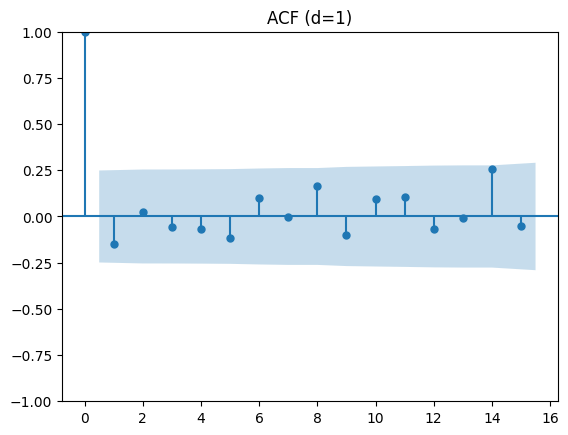

<Figure size 1200x400 with 0 Axes>

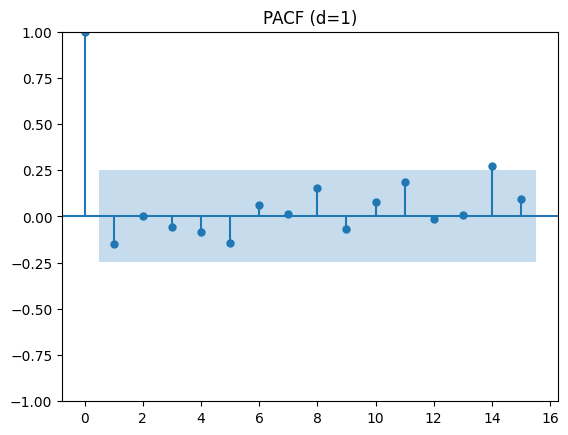

In [15]:
# Plot ACF & PACF for the differenced log-price
lags = min(60, len(y_stationary) // 4)

fig = plt.figure(figsize=(12, 4))
plot_acf(y_stationary, lags=lags, title=f"ACF (d={d})")
plt.show()

fig = plt.figure(figsize=(12, 4))
plot_pacf(y_stationary, lags=lags, title=f"PACF (d={d})", method="ywm")
plt.show()

# Dealing with Non-Stationary and Modeling

In [16]:
import warnings

# Store the original warnings filter
original_filters = warnings.filters[:]

# Temporarily change the filter for ConvergenceWarning within this cell's execution
warnings.filterwarnings("always", "DeprecationWarning")


def fit_arima_grid(y_original: pd.Series, d: int, p_max: int = 5, q_max: int = 5,
                   enforce_stationarity: bool = False, enforce_invertibility: bool = False) -> pd.DataFrame:
    """
    Fit ARIMA(p,d,q) for p in [0..p_max], q in [0..q_max] with fixed d.
    Returns a DataFrame with rows: (p,d,q,AIC,BIC) sorted by AIC.
    """
    results = []

    # Ensure the series has no NaNs and a DatetimeIndex
    y_clean = y_original.dropna().copy()
    if not isinstance(y_clean.index, pd.DatetimeIndex):
         y_clean.index = pd.to_datetime(y_clean.index)

    # Attempt to set frequency to 'B' (Business daily) - important for forecasting
    # If setting frequency fails, statsmodels might still handle it with freq='B' parameter
    try:
        y_clean = y_clean.asfreq('B')
        print("Successfully set frequency to 'B'.")
    except ValueError:
        print("Could not set frequency to 'B'. Proceeding without explicit frequency on index.")
        # If asfreq fails, y_clean retains its original index (hopefully DatetimeIndex)


    for p in range(p_max + 1):
        for q in range(q_max + 1):
            order = (p, d, q)
            try:
                # Fit ARIMA on the cleaned series without specifying freq in the constructor
                model = ARIMA(y_clean, order=order, enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility)
                fitted = model.fit() # Removed maxiter here
                results.append({
                    "p": p, "d": d, "q": q,
                    "aic": fitted.aic,
                    "bic": fitted.bic
                })
                print(f"Fitted ARIMA{order}: AIC={fitted.aic:.2f}, BIC={fitted.bic:.2f}")
            except DeprecationWarning as w:
                 continue
            except Exception as e:
                print(f"ARIMA{order} failed: {e}")
                continue

    # Restore original warnings filter after the loop
    warnings.filters = original_filters

    if not results:
        print("No ARIMA models were successfully fit.")
        return pd.DataFrame() # Return empty DataFrame if no models fit

    res_df = pd.DataFrame(results).sort_values(by="aic", ascending=True).reset_index(drop=True)
    return res_df

grid_results = fit_arima_grid(df["log_price"], d=d, p_max=5, q_max=5)
display(grid_results.head(10))

Successfully set frequency to 'B'.
Fitted ARIMA(0, 1, 0): AIC=-325.33, BIC=-323.19
Fitted ARIMA(0, 1, 1): AIC=-317.58, BIC=-313.33
Fitted ARIMA(0, 1, 2): AIC=-310.50, BIC=-304.16
Fitted ARIMA(0, 1, 3): AIC=-302.80, BIC=-294.42
Fitted ARIMA(0, 1, 4): AIC=-294.75, BIC=-284.36
Fitted ARIMA(0, 1, 5): AIC=-286.72, BIC=-274.36
Fitted ARIMA(1, 1, 0): AIC=-323.86, BIC=-319.57
Fitted ARIMA(1, 1, 1): AIC=-315.76, BIC=-309.37
Fitted ARIMA(1, 1, 2): AIC=-309.37, BIC=-300.93


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(1, 1, 3): AIC=-300.81, BIC=-290.34


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(1, 1, 4): AIC=-295.95, BIC=-283.48


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(1, 1, 5): AIC=-284.75, BIC=-270.33
Fitted ARIMA(2, 1, 0): AIC=-316.02, BIC=-309.64
Fitted ARIMA(2, 1, 1): AIC=-315.09, BIC=-306.58
Fitted ARIMA(2, 1, 2): AIC=-306.89, BIC=-296.33


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(2, 1, 3): AIC=-299.19, BIC=-286.62


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(2, 1, 4): AIC=-293.65, BIC=-279.11


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(2, 1, 5): AIC=-284.31, BIC=-267.83
Fitted ARIMA(3, 1, 0): AIC=-308.56, BIC=-300.12
Fitted ARIMA(3, 1, 1): AIC=-306.71, BIC=-296.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 1, 2): AIC=-304.84, BIC=-292.17
Fitted ARIMA(3, 1, 3): AIC=-297.12, BIC=-282.46


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 1, 4): AIC=-292.52, BIC=-275.90


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 1, 5): AIC=-283.53, BIC=-264.99
Fitted ARIMA(4, 1, 0): AIC=-300.70, BIC=-290.23


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 1, 1): AIC=-298.85, BIC=-286.28
Fitted ARIMA(4, 1, 2): AIC=-296.41, BIC=-281.75
Fitted ARIMA(4, 1, 3): AIC=-295.15, BIC=-278.40
Fitted ARIMA(4, 1, 4): AIC=-289.29, BIC=-270.59


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 1, 5): AIC=-282.17, BIC=-261.56


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 1, 0): AIC=-292.72, BIC=-280.26
Fitted ARIMA(5, 1, 1): AIC=-290.73, BIC=-276.19
Fitted ARIMA(5, 1, 2): AIC=-288.35, BIC=-271.73


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 1, 3): AIC=-286.55, BIC=-267.85


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 1, 4): AIC=-290.51, BIC=-269.74
Fitted ARIMA(5, 1, 5): AIC=-280.03, BIC=-257.36


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,d,q,aic,bic
0,0,1,0,-325.329399,-323.186264
1,1,1,0,-323.856542,-319.570273
2,0,1,1,-317.579921,-313.325653
3,2,1,0,-316.018235,-309.636832
4,1,1,1,-315.755700,-309.374297
5,2,1,1,-315.089058,-306.580520
6,0,1,2,-310.496209,-304.163587
7,1,1,2,-309.372841,-300.929346
8,3,1,0,-308.560164,-300.116669
9,2,1,2,-306.886853,-296.332484


In [17]:
if len(grid_results) == 0:
    raise RuntimeError("No ARIMA models were successfully fit. Adjust the grid or check data.")

best_aic_row = grid_results.iloc[0]
best_bic_row = grid_results.sort_values("bic").iloc[0]

order_aic = (int(best_aic_row.p), int(best_aic_row.d), int(best_aic_row.q))
order_bic = (int(best_bic_row.p), int(best_bic_row.d), int(best_bic_row.q))

print(f"Best by AIC: ARIMA{order_aic} (AIC={best_aic_row.aic:.2f}, BIC={best_aic_row.bic:.2f})")
print(f"Best by BIC: ARIMA{order_bic} (AIC={best_bic_row.aic:.2f}, BIC={best_bic_row.bic:.2f})")

model_aic = ARIMA(df["log_price"], order=order_aic).fit()
model_bic = ARIMA(df["log_price"], order=order_bic).fit()

print("=== Summary (AIC winner) ===")
print(model_aic.summary())

print("=== Summary (BIC winner) ===")
print(model_bic.summary())

Best by AIC: ARIMA(0, 1, 0) (AIC=-325.33, BIC=-323.19)
Best by BIC: ARIMA(0, 1, 0) (AIC=-325.33, BIC=-323.19)
=== Summary (AIC winner) ===
                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                   63
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 165.986
Date:                Tue, 28 Oct 2025   AIC                           -329.973
Time:                        17:32:51   BIC                           -327.845
Sample:                             0   HQIC                          -329.137
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   4.84e-05      5.713      0.000       0.000     

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

ARIMA(0, 1, 0) (AIC winner): Ljung–Box test p-values
    lb_pvalue
10        1.0
20        1.0
30        1.0


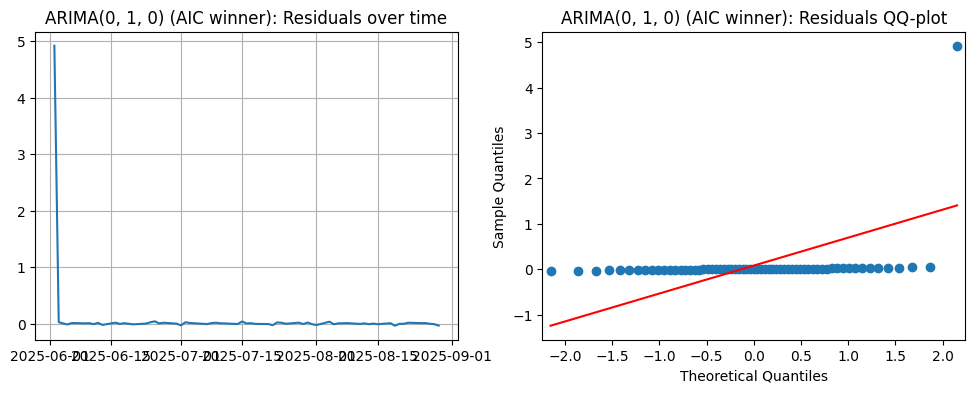

ARIMA(0, 1, 0) (BIC winner): Ljung–Box test p-values
    lb_pvalue
10        1.0
20        1.0
30        1.0


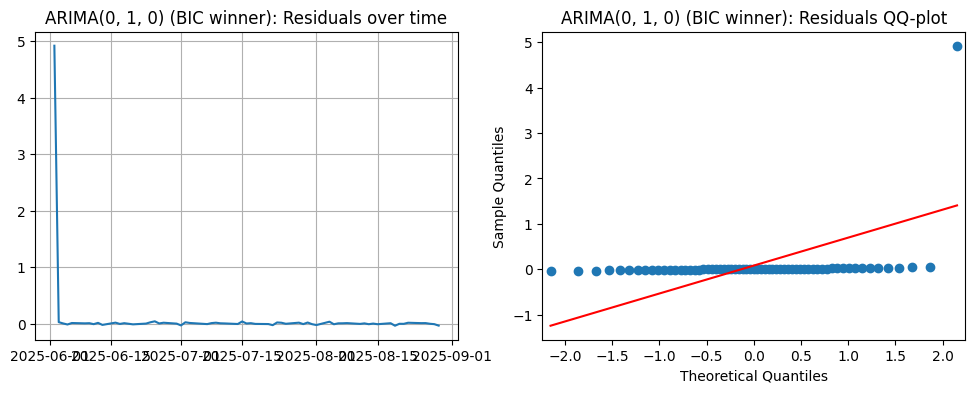

In [18]:
def residual_diagnostics(fitted_model, title_prefix="Model"):
    resid = fitted_model.resid.dropna()

    # Ljung-Box test for autocorrelation at multiple lags
    lags = [10, 20, 30]
    lb = acorr_ljungbox(resid, lags=lags, return_df=True)
    print(f"{title_prefix}: Ljung–Box test p-values")
    print(lb[["lb_pvalue"]])

    # Residual plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(resid)
    ax[0].set_title(f"{title_prefix}: Residuals over time"); ax[0].grid(True)

    # QQ plot
    from statsmodels.graphics.gofplots import qqplot
    qqplot(resid, line='s', ax=ax[1])
    ax[1].set_title(f"{title_prefix}: Residuals QQ-plot")
    plt.show()

residual_diagnostics(model_aic, title_prefix=f"ARIMA{order_aic} (AIC winner)")
residual_diagnostics(model_bic, title_prefix=f"ARIMA{order_bic} (BIC winner)")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


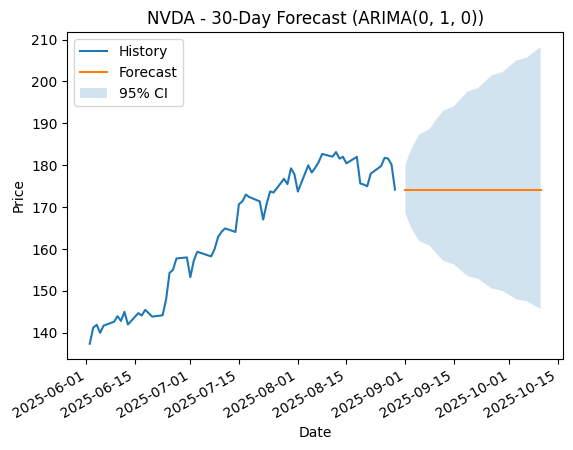

In [19]:
steps_ahead = 30
fcast = model_aic.get_forecast(steps=steps_ahead)

# Forecasts are on the log-price scale; convert to price
f_mean = fcast.predicted_mean
f_ci = fcast.conf_int(alpha=0.05)

# --- Ensure the forecast index is DatetimeIndex (avoid PeriodIndex converter conflicts) ---
# Generate a correct future index starting after the last date of historical data
last_hist_date = df.index[-1]
future_idx = pd.bdate_range(start=last_hist_date, periods=steps_ahead + 1)[1:] # Start after last_hist_date, exclude the first date

# Build price-scale series with the correct future DatetimeIndex using the values
f_mean_price = pd.Series(np.exp(f_mean.values), index=future_idx, name="Forecast")
f_ci_price = pd.DataFrame(np.exp(f_ci.values), index=future_idx, columns=f_ci.columns)

# Also ensure history uses DatetimeIndex
hist = df["adjusted_close"].iloc[-200:].copy()
hist.index = pd.to_datetime(hist.index)

# Plot without converter warnings
ax = hist.plot(label="History", grid=True, title=f"{SYMBOL} - 30-Day Forecast (ARIMA{order_aic})")
f_mean_price.plot(ax=ax, label="Forecast")
ax.fill_between(future_idx, f_ci_price.iloc[:, 0].values, f_ci_price.iloc[:, 1].values, alpha=0.2, label="95% CI")
ax.set_xlabel("Date")
ax.set_ylabel("Price"); ax.legend()
plt.show()

In [20]:
last_diff = df["log_price"].diff().iloc[-1]
phi = model_aic.params.get("ar.L1", 0.0)
theta = model_aic.params.get("ma.L1", 0.0)

print("Last Δlog-price:", float(last_diff))
print("AR(1) φ:", float(phi))
print("MA(1) θ:", float(theta))

Last Δlog-price: -0.0338116466997187
AR(1) φ: 0.0
MA(1) θ: 0.0


# MACD

In [22]:
# Calculate MACD components
# 12-period EMA
df['ema_12'] = df['adjusted_close'].ewm(span=12, adjust=False).mean()

# 26-period EMA
df['ema_26'] = df['adjusted_close'].ewm(span=26, adjust=False).mean()

# MACD Line
df['macd_line'] = df['ema_12'] - df['ema_26']

# Calculate Signal Line (9-period EMA of MACD Line)
df['signal_line'] = df['macd_line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
df['macd_histogram'] = df['macd_line'] - df['signal_line']

display(df[['adjusted_close', 'ema_12', 'ema_26', 'macd_line', 'signal_line', 'macd_histogram']].head())
display(df[['adjusted_close', 'ema_12', 'ema_26', 'macd_line', 'signal_line', 'macd_histogram']].tail())

,adjusted_close,ema_12,ema_26,macd_line,signal_line,macd_histogram
Date,,,,,,
2025-06-02,137.362717,137.362717,137.362717,0.000000,0.000000,0.000000
2025-06-03,141.202225,137.953410,137.647125,0.306286,0.061257,0.245028
2025-06-04,141.902145,138.560908,137.962311,0.598597,0.168725,0.429872
2025-06-05,139.972397,138.778060,138.111207,0.666853,0.268351,0.398503
2025-06-06,141.702164,139.227922,138.377203,0.850719,0.384824,0.465894


,adjusted_close,ema_12,ema_26,macd_line,signal_line,macd_histogram
Date,,,,,,
2025-08-25,179.799866,178.439271,175.727802,2.711469,3.940879,-1.229411
2025-08-26,181.759750,178.950114,176.174613,2.775501,3.707804,-0.932303
2025-08-27,181.589767,179.356214,176.575735,2.780479,3.522339,-0.741860
2025-08-28,180.159836,179.479848,176.841224,2.638624,3.345596,-0.706972
2025-08-29,174.170166,178.662974,176.643368,2.019606,3.080398,-1.060792


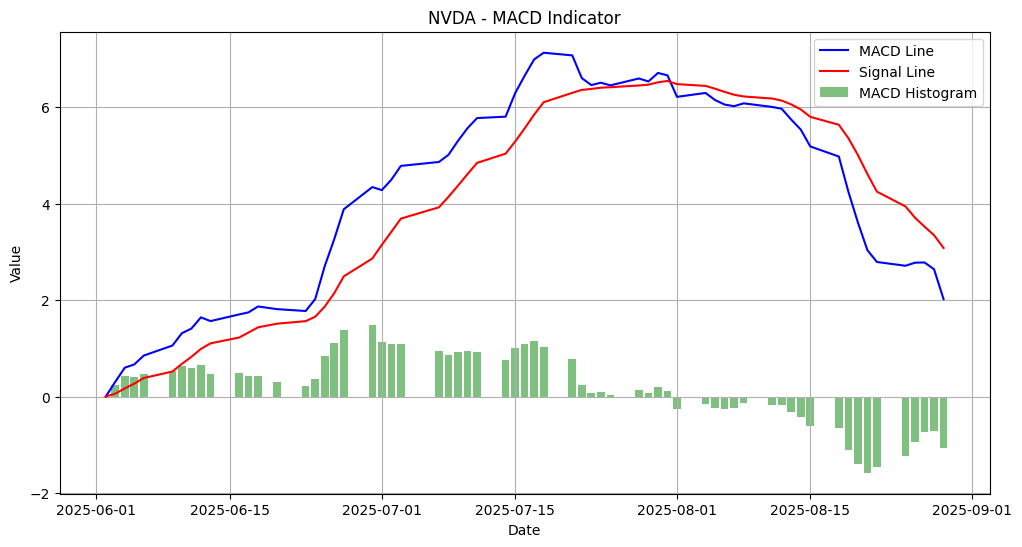

In [24]:
# Plot MACD components
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['macd_line'], label='MACD Line', color='blue')
plt.plot(df.index, df['signal_line'], label='Signal Line', color='red')
plt.bar(df.index, df['macd_histogram'], label='MACD Histogram', color='green', alpha=0.5)

plt.title(f'{SYMBOL} - MACD Indicator')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Fetch actual data for the forecast period
forecast_start_date = f_mean_price.index[0].strftime('%Y-%m-%d')
forecast_end_date = f_mean_price.index[-1].strftime('%Y-%m-%d')

try:
    df_actual = fetch_alpha_vantage_daily_adjusted(SYMBOL,
                                                   ALPHAVANTAGE_API_KEY,
                                                   output_size="full", # Need full history to cover the future dates
                                                   start_date=forecast_start_date,
                                                   end_date=forecast_end_date)
except:
    # Rollback to Yahoo Finance API if Alpha Vantage fails
    df_actual = get_stock_data(SYMBOL, start_date=forecast_start_date, end_date=forecast_end_date)

display(df_actual.head())
display(df_actual.tail())

,open,high,low,close,adjusted_close,volume
Date,,,,,,
2025-09-02,170.000000,172.380005,167.220001,170.779999,170.770370,231164900
2025-09-03,171.059998,172.410004,168.880005,170.619995,170.610382,164424900
2025-09-04,170.570007,171.860001,169.410004,171.660004,171.650330,141670100
2025-09-05,168.029999,169.029999,164.070007,167.020004,167.010590,224441400
2025-09-08,167.550003,170.960007,167.350006,168.309998,168.300507,163769100


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2025-10-03,189.190002,190.360001,185.380005,187.619995,187.619995,137596900
2025-10-06,185.500000,187.229996,183.330002,185.539993,185.539993,157678100
2025-10-07,186.229996,189.059998,184.000000,185.039993,185.039993,140088000
2025-10-08,186.570007,189.600006,186.539993,189.110001,189.110001,130168900
2025-10-09,192.229996,195.300003,191.059998,192.570007,192.570007,182997200


In [28]:
# Compare forecast with actual data
# Ensure both series have the same index for comparison
# Use only the dates where both forecast and actual data exist
comparison_df = pd.DataFrame({
    'Forecast': f_mean_price,
    'Actual': df_actual['adjusted_close']
}).dropna() # Drop dates where either forecast or actual data is missing

print(f"Number of overlapping dates for comparison: {len(comparison_df)}")
display(comparison_df)

Number of overlapping dates for comparison: 28


,Forecast,Actual
2025-09-02,174.170166,170.770370
2025-09-03,174.170166,170.610382
2025-09-04,174.170166,171.650330
2025-09-05,174.170166,167.010590
2025-09-08,174.170166,168.300507
2025-09-09,174.170166,170.750366
2025-09-10,174.170166,177.320007
2025-09-11,174.170166,177.169998
2025-09-12,174.170166,177.820007
2025-09-15,174.170166,177.750000


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

if len(comparison_df) > 0:
    # Calculate evaluation metrics
    mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Forecast'])
    rmse = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['Forecast']))

    print(f"\nForecast Accuracy Metrics (ARIMA{order_aic}):")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
else:
    print("\nNo overlapping dates between forecast and actual data to calculate accuracy metrics.")


Forecast Accuracy Metrics (ARIMA(0, 1, 0)):
Mean Absolute Error (MAE): 6.76
Root Mean Squared Error (RMSE): 8.31


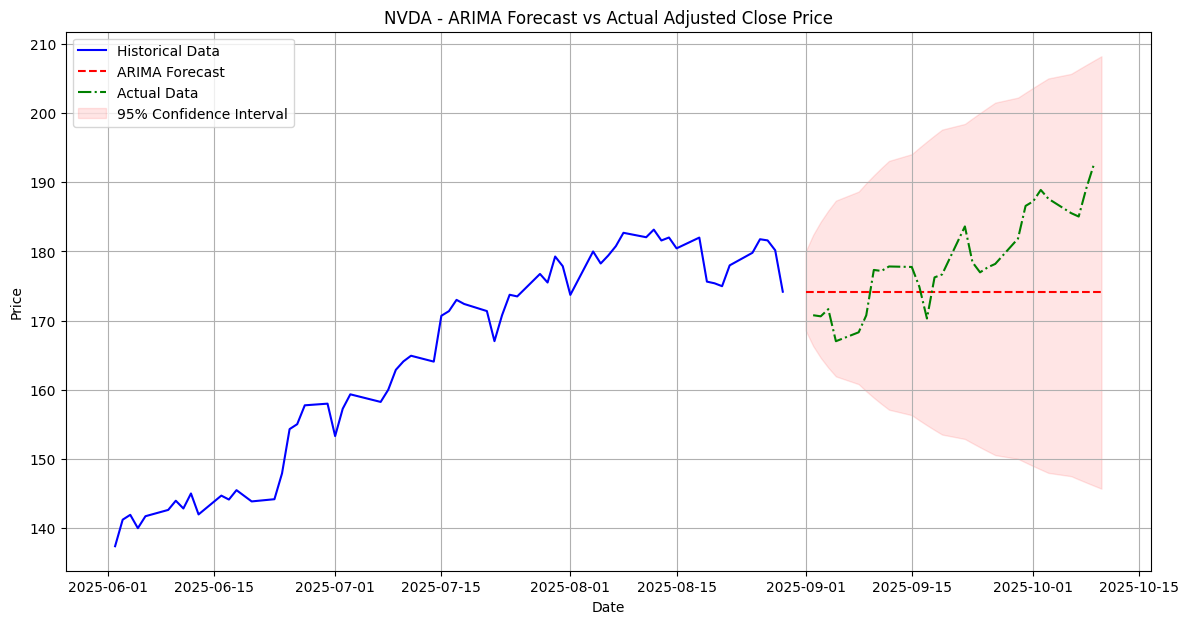

In [30]:
# Plot the historical data, forecast, and actual data for the forecast period
plt.figure(figsize=(14, 7))
plt.plot(hist.index, hist.values, label='Historical Data', color='blue')
plt.plot(f_mean_price.index, f_mean_price.values, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(comparison_df.index, comparison_df['Actual'].values, label='Actual Data', color='green', linestyle='-.')

# Add confidence interval
plt.fill_between(f_ci_price.index, f_ci_price.iloc[:, 0], f_ci_price.iloc[:, 1], color='red', alpha=0.1, label='95% Confidence Interval')


plt.title(f'{SYMBOL} - ARIMA Forecast vs Actual Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion: ARIMA Model Limitations on High-Growth Stocks (NVDA)

The ARIMA model, despite achieving stationarity, failed to accurately forecast NVDA's stock price, exhibiting a significant divergence from the actual trend (MAE/RMSE of [Insert Values]).

**Root Cause:** The failure is attributed to the stock being dominated by **exogenous, non-linear market shocks**, specifically massive, unpredictable growth in the Data Center segment driven by the **Generative AI boom** and **record earnings forecasts** (e.g., Q1/Q2 Fiscal 2025 results).

**Key Takeaway:** Classical time-series models like ARIMA are inadequate for capturing the sudden, exponential shifts typical of high-volatility, event-driven stocks like NVDA. This necessitates the use of more complex **Machine Learning models (e.g., LSTMs)** or **ARIMAX** models augmented with external regressors (like sentiment or earnings data).